# Conditioning and Guidance 2

In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise
from pathlib import Path
from tqdm import tqdm

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [2]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=12)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

In [3]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

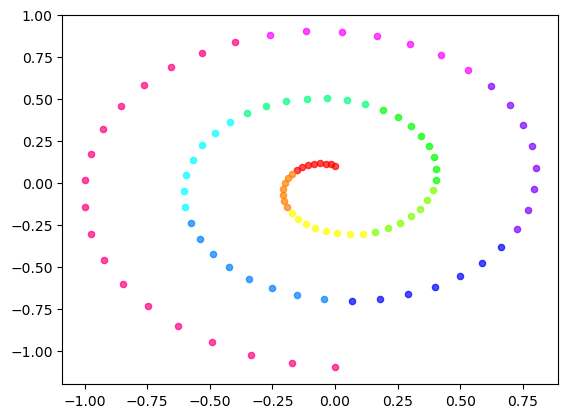

In [4]:
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)

In [5]:
labels

tensor([ 2,  9,  2,  3,  4,  3, 11, 11,  1,  1,  7,  0,  6,  3, 11,  2,  6,  9,
        11,  9, 10, 11,  7,  8,  7,  2,  4, 11,  1,  3,  7,  6,  4,  3, 11,  4,
         8, 11,  2,  5, 10, 11, 11,  8,  7, 10,  9, 11,  9,  7,  3,  5, 11,  2,
         4,  8,  7, 11,  3, 11,  8, 10,  6,  5, 11,  4,  1,  6,  6,  7,  0,  0,
         5,  5,  0,  0,  0,  9,  8,  2,  0,  8, 11,  1,  9, 11, 10,  1,  0,  5,
         4, 10,  4, 10, 11,  2,  9,  1,  5,  6])

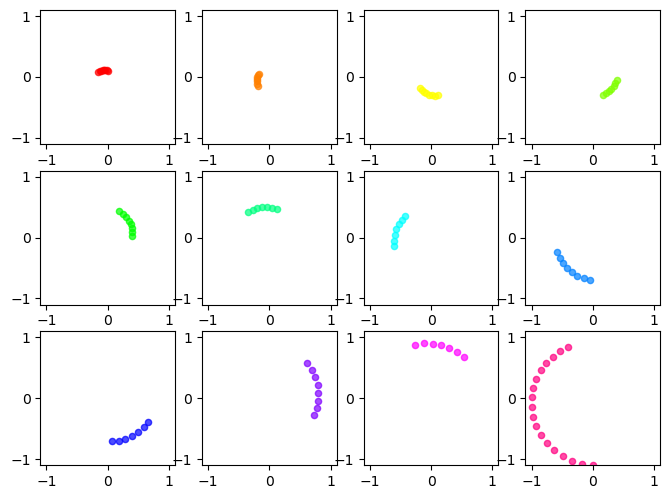

In [6]:
fig=plt.figure(0, (8,8))
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    fig.add_subplot(4,4,class_idx+1)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
    plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [7]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|█████████████████████████████████| 30000/30000 [04:31<00:00, 110.49it/s]


- Ok, what visualizations do I want here to support my writing? Probably something like:

1. Probably DDIM sampling - different colored flow lines by class - no guidance yes
2. Explore how conditioning on class impacts vectors fields (different colored arrows on top of eachother? maybe with fewer classes)
3. Guidance for sure - lines trailing particles for different guidance levels - and let's give a little thought to the geometry! 
4. Ok for geometry, I think i want to visualize the conditioned and unconditioned vector fields on top of each other right? That could be a pretty slick animation!
5. Bonus points for visualizing the conditioned vector field w/ a "negative" class ("i really don't want it to be x") - this will be cool too - ok let's get it!

## DDIM Paths

In [10]:
bound=1.5
num_heatmap_steps=30
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [16]:
grid.shape

torch.Size([900, 2])

In [56]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

N_sample=64 #Crank to 256 for nice viz? I guess I'll probably be re-doing this on the manim side, so I can crank there
sample_batch_size=100
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
for c in range(dataset.num_classes):
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            # heatmaps[-1].append(model.forward(grid, sig.to('cuda'), cond=cond))
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())

(-1.1, 1.1)

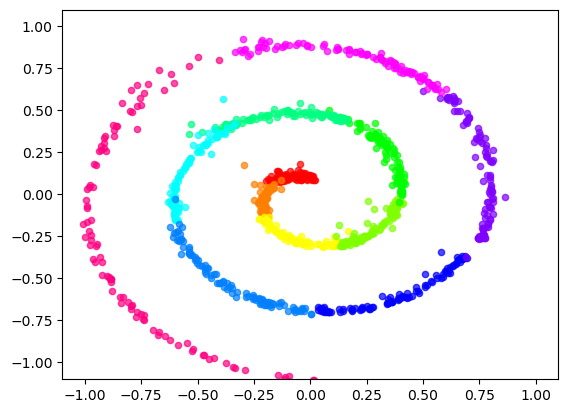

In [57]:
for class_idx in range(dataset.num_classes):
    plt.scatter(results_by_class[class_idx][:, 0], results_by_class[class_idx][:, 1], 
               c=[colors[class_idx]], alpha=0.7, s=20)
plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [58]:
save_dir=Path('/home/stephen/sora/jun_23_1')
save_dir.mkdir(exist_ok=True)

In [59]:
len(heatmaps)

12

In [60]:
len(heatmaps[0])

64

In [ ]:
for i in tqdm(range(len(heatmaps[0]))):
    for c, h in enumerate(heatmaps):
        
        plt.clf()
        fig=plt.figure(0, (7,7))
        
        heatmap_norm=torch.nn.functional.normalize(h[i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color=colors[class_idx])
        
        for j in range(32): #Just do a subset of trajetories
            plt.plot(xt_history[c][np.maximum(i-64, 0):i+1,j,0], xt_history[c][np.maximum(i-64, 0):i+1,j,1], '-', alpha=0.2, color=tuple(colors[class_idx]))
            plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[class_idx])
        
        viz_bounds=1.8
        plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
        # plt.axis('square')
        plt.savefig(save_dir/(str(i)+'.png'))

/tmp/ipykernel_19718/533946124.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[class_idx])
/tmp/ipykernel_19718/533946124.py:5: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (7,7))
  3%|█▎                                       | 2/64 [00:20<10:37, 10.29s/it]

In [67]:
xt_history[c][np.maximum(i-64, 0):i+1,j,0]

IndexError: index 100 is out of bounds for axis 1 with size 100

In [69]:
xt_history[c].shape

(64, 100, 2)

In [70]:
j

100

In [68]:
xt_history[c]

array([[[ 9.52076674e-01, -1.46064854e+01],
        [ 4.44308639e-01, -5.20840597e+00],
        [ 2.14142246e+01, -1.28923333e+00],
        ...,
        [-6.09879780e+00,  3.58074641e+00],
        [ 1.32853203e+01,  1.04127049e+00],
        [-1.32090273e+01, -1.92299676e+00]],

       [[ 7.81816661e-01, -1.27274799e+01],
        [ 3.70344222e-01, -4.62222767e+00],
        [ 1.93319607e+01, -1.11277807e+00],
        ...,
        [-5.56240416e+00,  3.23396921e+00],
        [ 1.19873505e+01,  9.67383027e-01],
        [-1.19179401e+01, -1.71760452e+00]],

       [[ 6.44391954e-01, -1.12103329e+01],
        [ 3.12663466e-01, -4.12429428e+00],
        [ 1.75732327e+01, -9.67312992e-01],
        ...,
        [-5.07363081e+00,  2.93231392e+00],
        [ 1.08858528e+01,  9.04801369e-01],
        [-1.07953568e+01, -1.53536749e+00]],

       ...,

       [[-1.02139823e-01,  8.23373720e-02],
        [-7.49908462e-02,  1.00935832e-01],
        [ 2.07489654e-02,  8.60823244e-02],
        ...,
     

In [64]:
tuple(colors[class_idx])

(1.0, 0.0, 0.5)

In [51]:
# xt_history[c]

In [52]:
np.maximum(i-64, 0)

0

In [53]:
xt_history[c][np.maximum(i-64, 0):i+1,j,0]

TypeError: list indices must be integers or slices, not tuple

In [55]:
len(xt_history[c])

64

In [28]:
colors[class_idx]

array([1. , 0. , 0.5])